In [1]:
import sys
import os
import gc
import cv2
import tqdm
import torch
import glob
import random
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import argparse
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.sparse import issparse
from sklearn.metrics.pairwise import cosine_similarity

# Add relative path
sys.path.append("../../")

from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything
# from Models.DeepPT.DeepPT_GNN import *
from Models.DeepPT.DeepPT_MessagePass import DeepPT_messagepass
from Dataloader.Dataset import *
# from Dataloader.Dataset_wiener import *


# parser = argparse.ArgumentParser()
# parser.add_argument('--fold', type=int, default=5, help='dataset fold.')
# parser.add_argument('--seed', type=int, default=42, help='random seed.')
# parser.add_argument('--colornorm', type=str, default="reinhard", help='Color normalization methods.')
# parser.add_argument('--dataset_name', type=str, default="SCC_Chenhao", help='Dataset choice.')
# parser.add_argument('--model_name', type=str, default="DeepPT_GNN", help='Model choice.')
# parser.add_argument('--gene_list', type=str, default="func", help='Gene list choice.')
# parser.add_argument('--gnn', type=str, default="gcn", help='Gene list choice.')
# parser.add_argument('--hpc', type=str, default="wiener", help='Clusters choice')
# args = parser.parse_args()

# fold = args.fold
# seed = args.seed
# colornorm = args.colornorm
# dataset_name = args.dataset_name
# model_name = args.model_name
# gene_list = args.gene_list
# hpc = args.hpc

"""
Hyperparameters settings
"""
hpc = "vmgpu"
fold = 1
seed = 42
dataset_name = "BC_visium"
colornorm = "raw"    # "reinhard", "raw"
model_name = "DeepPT_messagepass"  
gene_list = "func"
exp_norm = "lognorm"
gnn = "gcn"
PAG = True
SLG = False
HSG = False

print("Start training!")
print("Hyperparameters are as follows:")
print("Fold:", fold)
print("Color normalization method:", colornorm)
# print("Dataset_name:", dataset_name)
print("Model_name:", model_name)
print("gene_list:", gene_list)
print("exp_norm:", exp_norm)
print("cluster:", hpc)

if hpc == "wiener":
    abs_path = "/afm03/Q2/Q2051/DeepHis2Exp/Models/Benchmarking_main"
    model_weight_path = "/afm03/Q2/Q2051/DeepHis2Exp/Model_Weights"
   #  model_weight_path = "/scratch/imb/uqyjia11/Yuanhao/DeepHis2Exp/Model_Weights"
    res_path = "/afm03/Q2/Q2051/DeepHis2Exp/Results"
    data_path = "/afm03/Q2/Q2051/DeepHis2Exp/Dataset"
elif hpc == "vmgpu":
    abs_path = "/afm01/UQ/Q2051/DeepHis2Exp/Implementation"
    model_weight_path = "/afm01/UQ/Q2051/DeepHis2Exp/Model_Weights"
    res_path = "/afm01/UQ/Q2051/DeepHis2Exp/Results"
    data_path = "/afm01/UQ/Q2051/DeepHis2Exp/Dataset"
elif hpc == "bunya":
    abs_path = "/QRISdata/Q2051/DeepHis2Exp/Implementation"
    model_weight_path = "/QRISdata/Q2051/DeepHis2Exp/Model_Weights"
    res_path = "/QRISdata/Q2051/DeepHis2Exp/Results"
    data_path = "/QRISdata/Q2051/DeepHis2Exp/Dataset"

# For reproducing the results
seed_everything(seed)

# Load train and test dataset and wrap dataloader

# Functional genes for visium dataset
target_gene_list = list(np.load(f'{data_path}/Gene_list/Gene_list_{gene_list}_{dataset_name}.npy', allow_pickle=True))

# # Load sample names
# full_train_dataset = WeightedGraph_Anndata(fold=fold, gene_list=target_gene_list, num_subsets=50,
#                     train=True, r=112, exp_norm='lognorm', SLG=SLG, HSG=HSG, PAG=PAG,
#                     neighs=8, color_norm=colornorm, target=target, distance_mode="distance",)
# tr_loader = DataLoader(full_train_dataset, batch_size=1, shuffle=True)
# gc.collect()
# test_dataset = WeightedGraph_Anndata(fold=fold, gene_list=target_gene_list, num_subsets=50,
#                     train=False, r=112, exp_norm='lognorm', SLG=SLG, HSG=HSG, PAG=PAG,
#                     neighs=8, color_norm=colornorm, target=target, distance_mode="distance",)
# te_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# gc.collect()


Dataset path: /afm01/UQ/Q2051


Global seed set to 42


Start training!
Hyperparameters are as follows:
Fold: 1
Color normalization method: raw
Model_name: DeepPT_messagepass
gene_list: func
exp_norm: lognorm
cluster: vmgpu


In [ ]:
# Define model and train
model = DeepPT_messagepass(gnn=gnn, n_genes=len(target_gene_list), hidden_dim=512, learning_rate=1e-4)
    
# Empty cache of GPU
torch.cuda.empty_cache()

# Create folder to save model weights
if not os.path.isdir(f"{model_weight_path}/{dataset_name}/"):
    os.mkdir(f"{model_weight_path}/{dataset_name}/")
early_stop = pl.callbacks.EarlyStopping(monitor='train_loss', mode='min', patience=10)
checkpoint_callback = pl.callbacks.ModelCheckpoint(save_top_k=1, dirpath=f"{model_weight_path}", 
                                                   filename=f"{model_name}_{dataset_name}_{colornorm}_{test_dataset.te_names}", 
                                                   monitor="train_loss", mode="min")

trainer = pl.Trainer(accelerator='auto', 
                    callbacks=[early_stop, checkpoint_callback], 
                    max_epochs=100, logger=False)

# Start training and save best model
# trainer.fit(model, tr_loader)

# debug
trainer.fit(model, te_loader)

# print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
# print(checkpoint_callback.best_model_score) # and prints it score
# best_model = model.load_state_dict(torch.load(checkpoint_callback.best_model_path)["state_dict"])
# torch.save(torch.load(checkpoint_callback.best_model_path)["state_dict"], f"{model_weight_path}/{dataset_name}/{model_name}_PAG{str(PAG)}_HSG{str(HSG)}_{test_dataset.te_names}_{gene_list}.ckpt")
# os.remove(checkpoint_callback.best_model_path)
del model


In [ ]:
# Inference
gc.collect()
target_gene_list = test_dataset.gene_set
out = trainer.predict(model, te_loader)
pred = ad.AnnData(np.concatenate([out[i][0] for i in range(len(out))]))
gt_exp = np.concatenate([out[i][1] for i in range(len(out))])
gt = sc.concat([test_dataset.meta_dict[sub_slide] for sub_slide in list(test_dataset.meta_dict.keys())])[:,target_gene_list]
gt.X = gt_exp
        
# Add the gene list to AnnData    
pred.var_names = target_gene_list
gt.var_names = target_gene_list

# Save AnnData to H5AD file
if not os.path.isdir(f"{res_path}/{dataset_name}/"):
    os.mkdir(f"{res_path}/{dataset_name}/")
pred.write(f"{res_path}/{dataset_name}/pred_{model_name}_{dataset_name}_{colornorm}_{test_dataset.te_names}_{gene_list}.h5ad")
gt.write(f"{res_path}/{dataset_name}/gt_{model_name}_{dataset_name}_{colornorm}_{test_dataset.te_names}_{gene_list}.h5ad")
gc.collect()

# Save spatial location to numpy array
spatial_loc = np.concatenate([test_dataset.meta_dict[key].obsm["spatial"] for key in list(test_dataset.meta_dict.keys())])
np.save(f'{res_path}/{dataset_name}/spatial_loc_{model_name}_{dataset_name}_{colornorm}_{test_dataset.te_names}_{gene_list}.npy', spatial_loc)
gc.collect()

print("Finish training!")

# Generate results

In [2]:
def get_R(data1, data2, dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2
    
    r1,p1=[],[]
    for g in range(data1.shape[1]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g], alternative='greater')
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:], alternative='greater')
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_ssim(data1, data2, num_breaks=None):
    """
    Some info about SSIM computation.
    data1: the ground truth data
    data2: the predicted data
    dim: the dimension to calculate the SSIM. If the dim = 1, calculate the SSIM at gene-wise, otherwise calculate the SSIM at spot-wise.
    """
    adata1 = data1.X
    adata2 = data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2

    SSIM = []
    for g in range(adata1.shape[1]):
        x = adata1[:,g]
        y = adata2[:,g]
        # Normalize the arrays if their maximum values are not zero
        x = x if np.max(x) == 0 else x / np.max(x)
        y = y if np.max(y) == 0 else y / np.max(y)  
    
        if num_breaks:
            # Discretize the normalized arrays into 'num_breaks' bins
            x = np.digitize(x, np.linspace(0, 1, num_breaks), right=False) - 1
            y = np.digitize(y, np.linspace(0, 1, num_breaks), right=False) - 1
            
            # Constants used in SSIM calculation
            C1 = (0.01 * (num_breaks - 1))**2
            C2 = (0.03 * (num_breaks - 1))**2
        else:
            C1 = (0.01)**2
            C2 = (0.03)**2
        
        mux = np.mean(x)
        muy = np.mean(y) 
        sigxy = np.cov(x, y)[0, 1]
        sigx = np.var(x)
        sigy = np.var(y)
        
        ssim = ((2 * mux * muy + C1) * (2 * sigxy + C2)) / ((mux**2 + muy**2 + C1) * (sigx + sigy + C2))
        SSIM.append(ssim)
        assert -1 <= ssim <= 1, "SSIM should be within the valid range [-1, 1]"
        
    return SSIM

def get_cosine(data1, data2):
    # Convert the anndata to numpy array
    adata1=data1.X.T
    adata2=data2.X.T
    # Calculate the consine similarity at gene wise
    cosine_sim = cosine_similarity(adata1, adata2)
    # Take the diag of similarity matrix
    cosine_score = np.diag(cosine_sim)
    return cosine_score

In [ ]:
# For the graph construction
def make_res(names, PAG, HSG, SLG):
    for name in names:
        print(f"SLG:{SLG}, PAG:{PAG}, HSG:{HSG}, {name}")
        pred = sc.read_h5ad(f"{res_path}/New_GraphBuild/pred_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{name}_{gene_list}.h5ad")
        gt = sc.read_h5ad(f"{res_path}/New_GraphBuild/gt_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{name}_{gene_list}.h5ad")
        data1, data2 = gt, pred
        pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
        spc, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
        ssim_score = get_ssim(data1, data2)
        cosine_score = get_cosine(data1, data2)
        PCC_BC_Visium = {
                        "Gene": target_gene_list,
                        "Pearson correlation": pcc,
                        "PCC_PValue": PCC_PValue,
                        "Spearmanr correlation": spc,
                        "SPC_PValue": SPC_PValue,
                        "SSIM_Score": ssim_score,
                        "Cosine_Score": cosine_score,
                        # "Moran'I_Score": MI,
                        "Slides": [name]*len(pcc),
                        "Method": f"SLG:{SLG}, PAG:{PAG}, HSG:{HSG}"
                        }
        PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)    
        PCC_BC_Visium.to_csv(f"{res_path}/New_GraphBuild/{name}_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{gene_list}.csv")                        


In [23]:
# For the message passing
def make_res_messagepass(model_name, names, PAG, HSG, SLG):
    for name in names:
        print(f"SLG:{SLG}, PAG:{PAG}, HSG:{HSG}, {name}")
        pred = sc.read_h5ad(f"{res_path}/New_GraphBuild/pred_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{name}_{gene_list}.h5ad")
        gt = sc.read_h5ad(f"{res_path}/New_GraphBuild/gt_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{name}_{gene_list}.h5ad")
        data1, data2 = gt, pred
        pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
        spc, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
        ssim_score = get_ssim(data1, data2)
        cosine_score = get_cosine(data1, data2)
        PCC_BC_Visium = {
                        "Gene": target_gene_list,
                        "Pearson correlation": pcc,
                        "PCC_PValue": PCC_PValue,
                        "Spearmanr correlation": spc,
                        "SPC_PValue": SPC_PValue,
                        "SSIM_Score": ssim_score,
                        "Cosine_Score": cosine_score,
                        # "Moran'I_Score": MI,
                        "MessagePass": [model_name]*len(pcc),
                        "Slides": [name]*len(pcc),
                        "Method": f"SLG:{SLG}, PAG:{PAG}, HSG:{HSG}"
                        }
        PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)    
        PCC_BC_Visium.to_csv(f"{res_path}/New_GraphBuild/MessagePass/{name}_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{gene_list}.csv")                        


In [34]:
# Benchmarking message passing results
PAG = True
HSG = False
SLG = False
gnns = ["gcn", "gin", "gat"]
names = ['1142243F', '1160920F', 'CID4290', 'CID4465', 'CID44971', 'CID4535', ] # 'FFPE', 'block1', 'block2'
for gnn in gnns:
    model_name = f"DeepPT_{gnn}"
    make_res_messagepass(model_name, names, PAG, HSG, SLG)


SLG:False, PAG:True, HSG:False, 1142243F


SLG:False, PAG:True, HSG:False, 1160920F
SLG:False, PAG:True, HSG:False, CID4290
SLG:False, PAG:True, HSG:False, CID4465
SLG:False, PAG:True, HSG:False, CID44971
SLG:False, PAG:True, HSG:False, CID4535
SLG:False, PAG:True, HSG:False, 1142243F
SLG:False, PAG:True, HSG:False, 1160920F
SLG:False, PAG:True, HSG:False, CID4290
SLG:False, PAG:True, HSG:False, CID4465
SLG:False, PAG:True, HSG:False, CID44971
SLG:False, PAG:True, HSG:False, CID4535
SLG:False, PAG:True, HSG:False, 1142243F
SLG:False, PAG:True, HSG:False, 1160920F
SLG:False, PAG:True, HSG:False, CID4290
SLG:False, PAG:True, HSG:False, CID4465
SLG:False, PAG:True, HSG:False, CID44971
SLG:False, PAG:True, HSG:False, CID4535


In [ ]:
# Benchmarking graph construction results
names = ['1142243F', '1160920F', 'CID4290', 'CID4465', 'CID44971', 'CID4535', ] # 'FFPE', 'block1', 'block2'
model_name = "DeepPT_GNN"

# SLG
PAG = False
HSG = False
SLG = True
make_res(names, PAG, HSG, SLG)

# PAG
PAG = True
HSG = False
SLG = False
make_res(names, PAG, HSG, SLG)

# HSG
PAG = False
HSG = True
SLG = False
make_res(names, PAG, HSG, SLG)

# SLG + PAG
PAG = True
HSG = False
SLG = True
make_res(names, PAG, HSG, SLG)

# SLG + HSG
PAG = False
HSG = True
SLG = True
make_res(names, PAG, HSG, SLG)

# PAG + HSG
PAG = False
HSG = True
SLG = True
make_res(names, PAG, HSG, SLG)

# PAG + HSG + SLG
PAG = True
HSG = True
SLG = True
make_res(names, PAG, HSG, SLG)


In [44]:
def visualize_res(df, view, kind="Method", save_path="tmp.pdf"):
    # Collect garbage to free up memory
    gc.collect()

    if view == "local":
        # Set the font size for better readability
        plt.rcParams.update({'font.size': 16})

        # Create subplots with a 2x2 grid
        fig, axs = plt.subplots(2, 2, figsize=(18, 9))

        # List of columns and corresponding y-axis labels for plotting
        columns_to_plot = [
            ('Pearson correlation', 'Pearson correlation', False),
            ('Spearmanr correlation', 'Spearmanr correlation', False),
            ('Cosine_Score', 'Cosine Score', False),
            ('SSIM_Score', 'SSIM Score', False),
        ]

        # Loop through the columns and plot on the corresponding subplot
        for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
            row_index = i // 2
            col_index = i % 2
            sns.boxplot(x='Slides', y=column, hue=kind, data=df, ax=axs[row_index, col_index], showfliers=False, orient="v")
            
            # Rotate x-axis labels with 10 degrees
            axs[row_index, col_index].tick_params(axis='x', labelrotation=20)
            
            # Remove legend for all subplots except the first one
            if not add_legend:
                axs[row_index, col_index].get_legend().remove()

            axs[row_index, col_index].set_xlabel('')  # Remove x label for all subplots
            
            # Set y-axis label
            axs[row_index, col_index].set_ylabel(ylabel)

        # Adjust layout to prevent overlapping
        plt.tight_layout()

        # Save the plots as a PDF file
        plt.savefig(save_path)

        # Show the plots
        plt.show()

        # Collect garbage to free up memory
        gc.collect()
    elif view == "global":
        ax = sns.boxplot(x=kind, y='Pearson correlation', hue=kind, data=df, showfliers=False)

        # Move the legend above the plot
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=len(df[kind].unique()))


In [35]:
graph_build = pd.concat([pd.read_csv(i) for i in glob.glob(f"{res_path}/New_GraphBuild/*csv")])
messagepass = pd.concat([pd.read_csv(i) for i in glob.glob(f"{res_path}/New_GraphBuild/MessagePass/*csv")])


In [36]:
messagepass

,Unnamed: 0,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,MessagePass,Slides,Method
0,0,TCL1A,-0.002058,0.552094,-0.003217,0.581089,0.000322,0.025927,DeepPT_gat,1142243F,"SLG:False, PAG:True, HSG:False"
1,1,NODAL,0.023062,0.071134,0.022307,0.077900,-0.000003,0.010465,DeepPT_gat,1142243F,"SLG:False, PAG:True, HSG:False"
2,2,MCM7,0.008940,0.284753,0.000852,0.478380,0.011126,0.746002,DeepPT_gat,1142243F,"SLG:False, PAG:True, HSG:False"
3,3,COMMD3,0.029718,0.029307,0.024760,0.057572,0.008956,0.411170,DeepPT_gat,1142243F,"SLG:False, PAG:True, HSG:False"
4,4,VEGFC,-0.000606,0.515376,-0.005379,0.633914,0.002306,0.123020,DeepPT_gat,1142243F,"SLG:False, PAG:True, HSG:False"
...,...,...,...,...,...,...,...,...,...,...,...
1625,1625,CCL27,-0.002146,0.529592,-0.008361,0.613842,0.001070,0.080449,DeepPT_gcn,CID4465,"SLG:False, PAG:True, HSG:False"
1626,1626,HLA-DQA1,0.039115,0.087855,-0.053909,0.969042,0.044862,0.912719,DeepPT_gcn,CID4465,"SLG:False, PAG:True, HSG:False"
1627,1627,WNT3,0.020878,0.234971,0.001147,0.484171,0.002722,0.200886,DeepPT_gcn,CID4465,"SLG:False, PAG:True, HSG:False"
1628,1628,NASP,0.067038,0.010104,0.072601,0.005940,0.028533,0.790118,DeepPT_gcn,CID4465,"SLG:False, PAG:True, HSG:False"


In [ ]:
graph_build.replace("SLG:True, PAG:False, HSG:False", "SLG", inplace=True)
graph_build.replace("SLG:False, PAG:True, HSG:False", "PAG", inplace=True)
graph_build.replace("SLG:False, PAG:False, HSG:True", "HSG", inplace=True)
graph_build.replace("SLG:True, PAG:True, HSG:False", "SLG + PAG", inplace=True)
graph_build.replace("SLG:True, PAG:False, HSG:True", "SLG + HSG", inplace=True)
graph_build.replace("SLG:False, PAG:True, HSG:True", "HSG + PAG", inplace=True)
graph_build.replace("SLG:True, PAG:True, HSG:True", "SLG + HSG + PAG", inplace=True)
graph_build.sort_values(by="Method", ascending=True, inplace=True)


In [41]:
messagepass.replace("DeepPT_gat", "DeepPT_GAT", inplace=True)
messagepass.replace("DeepPT_gin", "DeepPT_GIN", inplace=True)
messagepass.replace("DeepPT_gcn", "DeepPT_GCN", inplace=True)
messagepass.sort_values(by="Method", ascending=True, inplace=True)


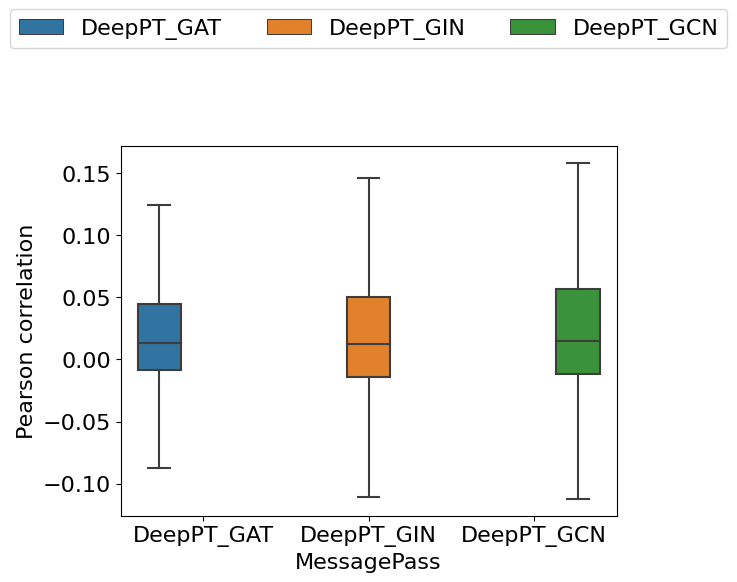

In [45]:
visualize_res(messagepass, "global", "MessagePass")

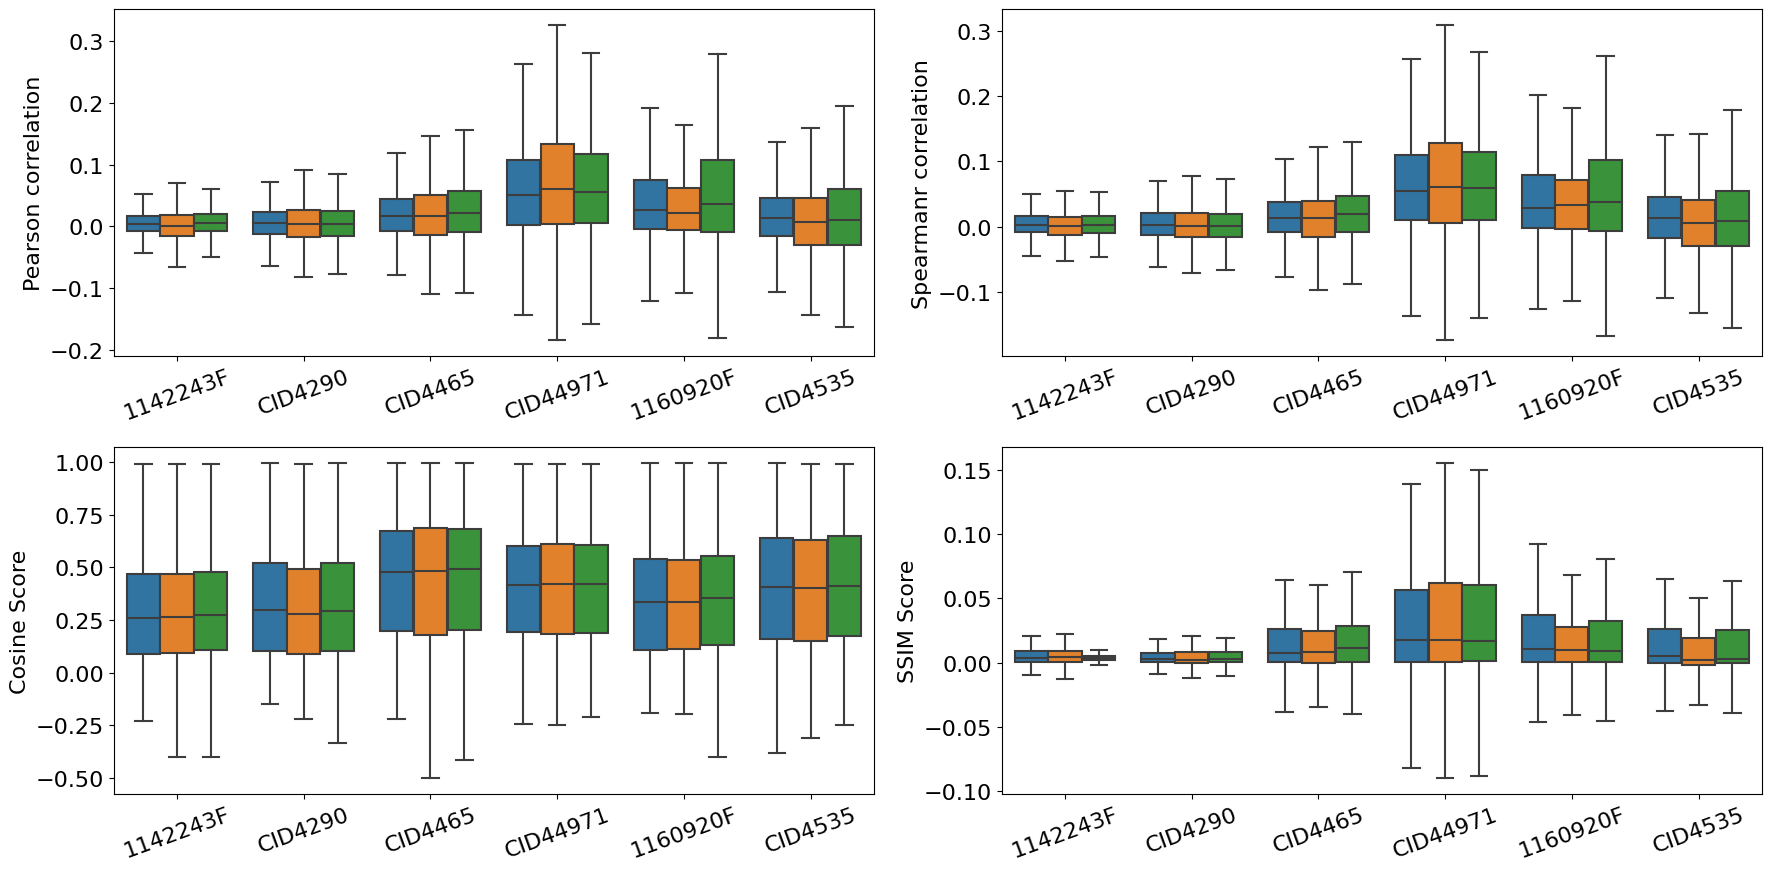

In [43]:
visualize_res(messagepass, "local", "MessagePass")